In [14]:
from apify_client import ApifyClient
from dotenv import load_dotenv
import os
import streamlit as st
import pandas as pd
from joblib import load
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import pandas as pd
import requests
# from app import username


# Load environment variables from .env file
load_dotenv()

# Access environment variables
api_key = os.environ['API_KEY']

# Initialize the ApifyClient with your API token
client = ApifyClient(api_key)

def scrap_tweet (username):
    # Prepare the Actor input
    run_input = {
        "customMapFunction": "(object) => { return {...object} }",
        "maxItems": 10,
        "onlyImage": False,
        "onlyQuote": False,
        "onlyTwitterBlue": False,
        "onlyVerifiedUsers": False,
        "onlyVideo": False,
        "sort": "Top",
        "dateFrom" : 2024-2-5,
        "dateTo" : 2024-2-10,
        "twitterHandles": username
    }

    # Run the Actor and wait for it to finish
    run = client.actor("apidojo/tweet-scraper")\
            .call(run_input=run_input, timeout_secs=6000, memory_mbytes=256, build="latest")

    items_list = []

    # Fetch and print Actor results from the run's dataset (if there are any)
    for item in client.dataset(run["defaultDatasetId"]).iterate_items():
        items_list.append(item)
        
    print("Total Data Scraping: "+ str(len(items_list)))
    return items_list

def take_dataframe(data):
    df_tweet = []
    for i in data:
        data = [i['text'],
                i['createdAt']]
        df_tweet.append(data)

    df_tweet=pd.DataFrame(df_tweet, columns = ['text','createdAt'])
    return df_tweet



In [15]:
def preprocess_text(text):
    # Mengubah kalimat menjadi huruf kecil
    text = text.lower()

    # Menghapus tanda baca dari kalimat
    text = re.sub(r'[^\w\s]', '', text)

    # Menghapus spasi di awal dan akhir kalimat
    text = text.strip()
    return text

In [18]:
label_meanings = {
    0: 'Neutral',
    1: 'Positive',
    2: 'Negative',
    3: 'Insulting the Government',
    4: 'Insulting or Defaming Others',
    5: 'Threatening Others',
    6: 'Alluding to the Tribe, Religion, Race, and Intergroup'
}

In [16]:
def get_predict(filter_data):
    with open('best_rf_model.pkl', 'rb') as model_file:
        best_rf_model = pickle.load(model_file)

    with open('tfidf_vectorizer.pkl', 'rb') as vectorizer_file:
        vectorizer = pickle.load(vectorizer_file)

    # TF-IDF Vectorization pada data yang ingin diprediksi
    data_tfidf = vectorizer.transform(filter_data['text'])
    predictions = best_rf_model.predict(data_tfidf)
    netral_class_probabilities = best_rf_model.predict_proba(data_tfidf)[:, 0]

    # Add the predicted probabilities to the DataFrame
    filter_data['predicted_prob_netral'] = netral_class_probabilities

    # Tambahkan kolom hasil prediksi ke dalam DataFrame
    filter_data['predicted_sentiment'] = predictions
    filter_data['meaning'] = filter_data['predicted_sentiment'].map(label_meanings)
    return filter_data

In [19]:
username = ['jokowi']
data = scrap_tweet(username)
filter_data_text = take_dataframe(data)
filter_data_text

12-Feb-24 10:07:25 - HTTP Request: POST https://api.apify.com/v2/acts/apidojo~tweet-scraper/runs?build=latest&memory=256&timeout=6000 "HTTP/1.1 201 Created"
12-Feb-24 10:07:27 - HTTP Request: GET https://api.apify.com/v2/actor-runs/ldzWeK6KZ8GNd9gYq?waitForFinish=999999 "HTTP/1.1 200 OK"
12-Feb-24 10:07:39 - HTTP Request: GET https://api.apify.com/v2/datasets/XSAKndhaA9uegSIk9/items?offset=0&limit=1000 "HTTP/1.1 200 OK"
Total Data Scraping: 15


,text,createdAt
0,Menerima Kunjungan Menlu Malaysia. Meresmikan ...,Sun Feb 11 10:53:57 +0000 2024
1,Menikmati akhir pekan dengan menemani cucu-cuc...,Sun Feb 11 04:41:36 +0000 2024
2,Bersilaturahmi dengan peserta Jaminan Kesehata...,Wed Feb 07 14:40:14 +0000 2024
3,"Selamat kepada Rahmat Erwin Abdullah, Atlet an...",Wed Feb 07 13:26:02 +0000 2024
4,"Rabu, 7 Februari 2024, saya sempat meninjau fa...",Wed Feb 07 12:42:41 +0000 2024
5,Silaturahmi bersama nasabah program Membina Ek...,Wed Feb 07 09:44:04 +0000 2024
6,"Aparatur Sipil Negara (ASN), TNI, Polri, hingg...",Wed Feb 07 09:21:48 +0000 2024
7,"Rabu, 7 Februari 2024, saya meresmikan jalan t...",Wed Feb 07 07:37:47 +0000 2024
8,"Selamat Rizky Faidan, Elga Cahaya Putra dan Ak...",Tue Feb 06 14:40:18 +0000 2024
9,"Selasa, 6 Februari 2024, saya menerima kunjung...",Tue Feb 06 14:18:18 +0000 2024


In [20]:
filter_data_text['text'] = filter_data_text['text'].apply(preprocess_text)

In [21]:
filter_data_text

,text,createdAt
0,menerima kunjungan menlu malaysia meresmikan j...,Sun Feb 11 10:53:57 +0000 2024
1,menikmati akhir pekan dengan menemani cucucucu...,Sun Feb 11 04:41:36 +0000 2024
2,bersilaturahmi dengan peserta jaminan kesehata...,Wed Feb 07 14:40:14 +0000 2024
3,selamat kepada rahmat erwin abdullah atlet ang...,Wed Feb 07 13:26:02 +0000 2024
4,rabu 7 februari 2024 saya sempat meninjau fasi...,Wed Feb 07 12:42:41 +0000 2024
5,silaturahmi bersama nasabah program membina ek...,Wed Feb 07 09:44:04 +0000 2024
6,aparatur sipil negara asn tni polri hingga bad...,Wed Feb 07 09:21:48 +0000 2024
7,rabu 7 februari 2024 saya meresmikan jalan tol...,Wed Feb 07 07:37:47 +0000 2024
8,selamat rizky faidan elga cahaya putra dan akb...,Tue Feb 06 14:40:18 +0000 2024
9,selasa 6 februari 2024 saya menerima kunjungan...,Tue Feb 06 14:18:18 +0000 2024


In [22]:
predict_tweet = get_predict(filter_data_text)
print("hasil predicted :")
predict_tweet

hasil predicted :


,text,createdAt,predicted_prob_netral,predicted_sentiment,meaning
0,menerima kunjungan menlu malaysia meresmikan j...,Sun Feb 11 10:53:57 +0000 2024,0.000000,1.0,Positive
1,menikmati akhir pekan dengan menemani cucucucu...,Sun Feb 11 04:41:36 +0000 2024,0.000000,1.0,Positive
2,bersilaturahmi dengan peserta jaminan kesehata...,Wed Feb 07 14:40:14 +0000 2024,0.373143,0.0,Neutral
3,selamat kepada rahmat erwin abdullah atlet ang...,Wed Feb 07 13:26:02 +0000 2024,0.040000,1.0,Positive
4,rabu 7 februari 2024 saya sempat meninjau fasi...,Wed Feb 07 12:42:41 +0000 2024,0.533143,0.0,Neutral
5,silaturahmi bersama nasabah program membina ek...,Wed Feb 07 09:44:04 +0000 2024,0.160000,1.0,Positive
6,aparatur sipil negara asn tni polri hingga bad...,Wed Feb 07 09:21:48 +0000 2024,0.000000,1.0,Positive
7,rabu 7 februari 2024 saya meresmikan jalan tol...,Wed Feb 07 07:37:47 +0000 2024,0.000000,1.0,Positive
8,selamat rizky faidan elga cahaya putra dan akb...,Tue Feb 06 14:40:18 +0000 2024,0.020000,1.0,Positive
9,selasa 6 februari 2024 saya menerima kunjungan...,Tue Feb 06 14:18:18 +0000 2024,0.020000,3.0,Insulting the Government


C:\Users\alfin\AppData\Local\Temp\ipykernel_12548\389132120.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='meaning', data=filter_data_text, palette='viridis', order=value_counts_result.index, ax=ax)


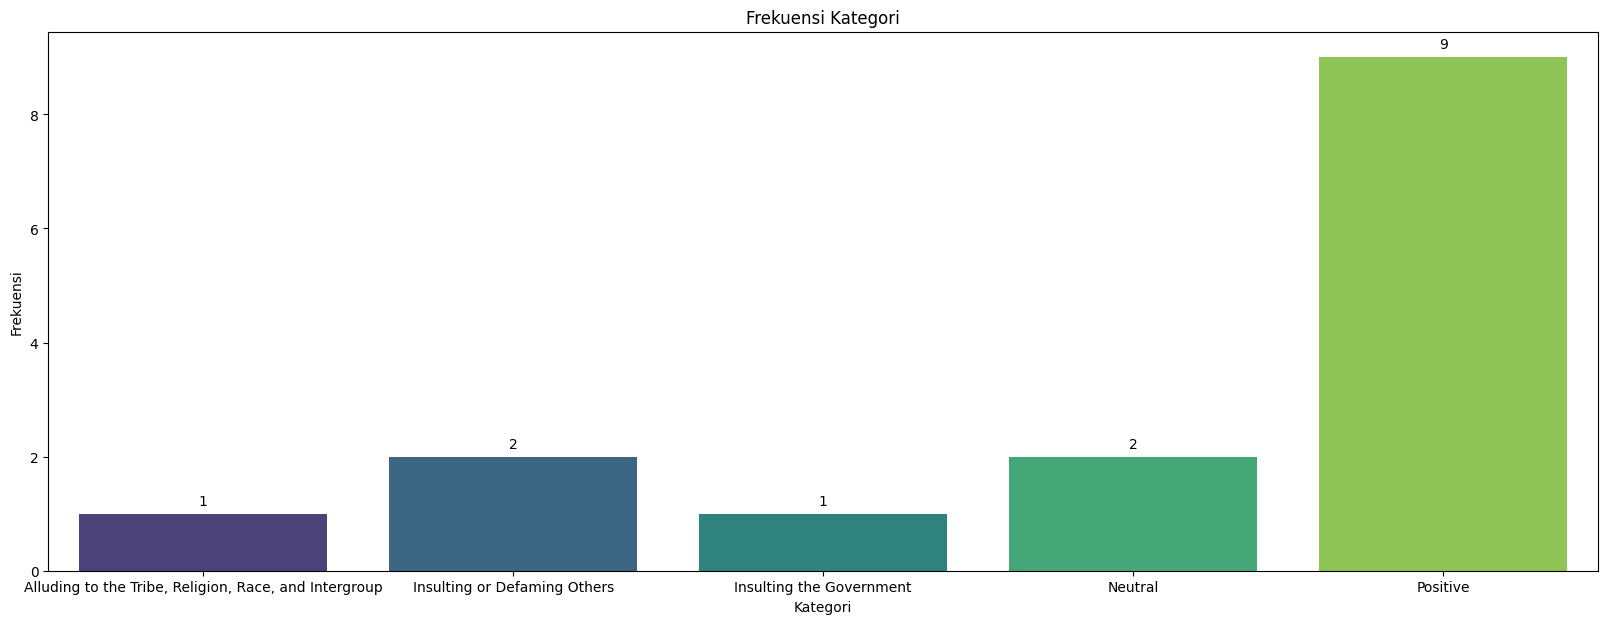

In [28]:
value_counts_result = filter_data_text['meaning'].value_counts().sort_index()

# Membuat visualisasi dengan Seaborn
fig, ax = plt.subplots(figsize=(20, 7))
sns.countplot(x='meaning', data=filter_data_text, palette='viridis', order=value_counts_result.index, ax=ax)

# Menambahkan nilai frekuensi di atas setiap batang histogram
for i, value in enumerate(value_counts_result):
    ax.text(i, value + 0.1, str(value), ha='center', va='bottom')

ax.set_title('Frekuensi Kategori')
ax.set_xlabel('Kategori')
ax.set_ylabel('Frekuensi')

# Menampilkan grafik menggunakan st.pyplot(fig)
plt.show(fig)

In [30]:
def Convert(string):
    li = list(string.split(" "))
    return li
 
# Driver code
username = 'jokwo'
print(Convert(username))

['jokwo']
